## 1. Importing Required PyTorch Modules

In [42]:
!pip install torchinfo

In [43]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torchinfo import summary
import torch.nn as nn
import matplotlib.pyplot as plt

## 2. Downloading and Preparing the FashionMNIST Dataset

In [44]:
# Download and load the training data for the FashionMNIST dataset.
# - 'root': Directory where the data will be stored.
# - 'train': Specifies whether to download the training set (True).
# - 'download': Downloads the dataset if it isn't already downloaded.
# - 'transform': Applies a transformation to the data (e.g., converting images to tensors).
training_data = datasets.FashionMNIST(
    root="data",       # Path to save the dataset.
    train=True,        # Load the training data.
    download=True,     # Download the dataset if not already present.
    transform=ToTensor(),  # Transform images to PyTorch tensors.
)

# Download and load the test data for the FashionMNIST dataset.
# - Similar to the training data, but 'train' is set to False to download the test set.
test_data = datasets.FashionMNIST(
    root="data",       # Path to save the dataset.
    train=False,       # Load the test data.
    download=True,     # Download the dataset if not already present.
    transform=ToTensor(),  # Transform images to PyTorch tensors.
)

In [45]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## 3. Setting Up the Device for Model Trainin

In [46]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## 4. Defining and Initializing the Neural Network Model


In [47]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # Convolutional Layer: 1 input channel, 16 output channels, 3x3 kernel
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max Pooling: Downsample spatial dimensions by a factor of 2

            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # Convolutional Layer: 16 input channels, 32 output channels, 3x3 kernel
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max Pooling: Downsample spatial dimensions by a factor of 2

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Convolutional Layer: 32 input channels, 64 output channels, 3x3 kernel
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max Pooling: Downsample spatial dimensions by a factor of 2
        )
        self.flatten = nn.Flatten()  # Flatten the output from convolutional layers for the fully connected layers
        self.fc_stack = nn.Sequential(
            nn.Linear(64 * 3 * 3, 128),  # Fully connected layer: 64*3*3 input features, 128 output features
            nn.ReLU(),  # Activation function
            nn.Linear(128, 10),  # Fully connected layer: 128 input features, 10 output features (number of classes)
        )

    def forward(self, x):
        x = self.conv_relu_stack(x)  # Apply the convolutional and pooling layers
        x = self.flatten(x)          # Flatten the output for the fully connected layers
        x = self.fc_stack(x)         # Apply the fully connected layers
        return x

# Instantiate the model and move it to the specified device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

# Generate the summary
summary(model, input_size=(64, 1, 28, 28))  # Summary with batch size 64, 1 channel, 28x28 input size

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [64, 10]                  --
├─Sequential: 1-1                        [64, 64, 3, 3]            --
│    └─Conv2d: 2-1                       [64, 16, 28, 28]          160
│    └─ReLU: 2-2                         [64, 16, 28, 28]          --
│    └─MaxPool2d: 2-3                    [64, 16, 14, 14]          --
│    └─Conv2d: 2-4                       [64, 32, 14, 14]          4,640
│    └─ReLU: 2-5                         [64, 32, 14, 14]          --
│    └─MaxPool2d: 2-6                    [64, 32, 7, 7]            --
│    └─Conv2d: 2-7                       [64, 64, 7, 7]            18,496
│    └─ReLU: 2-8                         [64, 64, 7, 7]            --
│    └─MaxPool2d: 2-9                    [64, 64, 3, 3]            --
├─Flatten: 1-2                           [64, 576]                 --
├─Sequential: 1-3                        [64, 10]                  --
│    └─

## 5. Defining the Loss Function and Optimizer

### 5.1. Selecting the Loss Function

In [48]:
# Define the loss function
# - nn.CrossEntropyLoss() computes the cross-entropy loss between the predicted logits and true labels.
# - It combines nn.LogSoftmax() and nn.NLLLoss() in a single step.
# - This is commonly used for multi-class classification tasks.
loss_fn = nn.CrossEntropyLoss()

### 5.2. Choosing the Optimizer

In [49]:
# Define the optimizer
# - torch.optim.SGD: Implements stochastic gradient descent (SGD) optimization.
# - 'model.parameters()': Passes the parameters of the model to the optimizer for updates.
# - 'lr=1e-3': Sets the learning rate to 0.001 for gradient updates.
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

## 6. Model Training and Testing

In [50]:
# Lists to store accuracy and loss values for training and testing
train_accuracies = []  # Store training accuracy for each epoch
test_accuracies = []   # Store test accuracy for each epoch
train_losses = []      # Store training loss for each epoch
test_losses = []       # Store test loss for each epoch

### 6.1. Defining the Training Function

In [51]:
# Define the training function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)  # Total number of samples in the training dataset
    model.train()  # Set the model to training mode

    correct = 0  # Counter for correct predictions (used to calculate accuracy)
    train_loss = 0  # Accumulator for cumulative loss over the epoch

    # Iterate over batches in the dataloader
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)  # Move data and labels to the specified device

        # Forward pass: Compute predictions and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation and optimization
        loss.backward()        # Compute gradients
        optimizer.step()        # Update model parameters
        optimizer.zero_grad()   # Reset gradients for the next batch

        # Accumulate loss and correct predictions for the batch
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Print progress every 100 batches
        if batch % 100 == 0:
            loss_value = loss.item()  # Current batch loss
            current = (batch + 1) * len(X)  # Number of samples processed so far
            print(f"loss: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")

    # Calculate average loss and accuracy for the epoch
    avg_loss = train_loss / len(dataloader)  # Average loss over all batches
    accuracy = 100 * correct / size  # Accuracy as a percentage
    train_losses.append(avg_loss)  # Append the average training loss to the list
    train_accuracies.append(accuracy)  # Append the training accuracy to the list

    # Print test results for the current epoch
    print(f"\nTrain Error: \n Accuracy: {accuracy:>0.1f}%, Avg loss: {avg_loss:>8f} \n")

### 6.2. Defining the Testing Function

In [52]:
# Define the testing function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)  # Total number of samples in the test dataset
    num_batches = len(dataloader)  # Total number of batches in the test dataloader
    model.eval()  # Set the model to evaluation mode

    test_loss, correct = 0, 0  # Initialize accumulators for loss and correct predictions

    with torch.no_grad():  # Disable gradient computation for evaluation
        # Iterate over batches in the test dataloader
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)  # Move data and labels to the specified device
            pred = model(X)  # Forward pass to compute predictions
            test_loss += loss_fn(pred, y).item()  # Accumulate batch loss
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()  # Count correct predictions

    # Calculate average loss and accuracy for the test dataset
    avg_loss = test_loss / num_batches  # Average loss over all test batches
    accuracy = 100 * correct / size  # Accuracy as a percentage
    test_losses.append(avg_loss)  # Append the average test loss to the list
    test_accuracies.append(accuracy)  # Append the test accuracy to the list

    # Print test results for the current epoch
    print(f"Test Error: \n Accuracy: {accuracy:>0.1f}%, Avg loss: {avg_loss:>8f} \n")

### 6.3. Training Loop and Model Evaluation

In [63]:
# Training loop
epochs = 10 # Number of epochs to train the model
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)  # Train the model on the training dataset
    test(test_dataloader, model, loss_fn)  # Evaluate the model on the test dataset

print("Done!")  # Print when training is complete

Epoch 1
-------------------------------
loss: 0.527456  [   64/60000]
loss: 0.593040  [ 6464/60000]
loss: 0.404885  [12864/60000]
loss: 0.621495  [19264/60000]
loss: 0.663949  [25664/60000]
loss: 0.703001  [32064/60000]
loss: 0.593056  [38464/60000]
loss: 0.584342  [44864/60000]
loss: 0.606063  [51264/60000]
loss: 0.636439  [57664/60000]

Train Error: 
 Accuracy: 78.9%, Avg loss: 0.579708 

Test Error: 
 Accuracy: 77.9%, Avg loss: 0.608100 

Epoch 2
-------------------------------
loss: 0.527456  [   64/60000]
loss: 0.593040  [ 6464/60000]
loss: 0.404885  [12864/60000]
loss: 0.621495  [19264/60000]
loss: 0.663949  [25664/60000]
loss: 0.703001  [32064/60000]
loss: 0.593056  [38464/60000]
loss: 0.584342  [44864/60000]
loss: 0.606063  [51264/60000]
loss: 0.636439  [57664/60000]

Train Error: 
 Accuracy: 78.9%, Avg loss: 0.579708 

Test Error: 
 Accuracy: 77.9%, Avg loss: 0.608100 

Epoch 3
-------------------------------
loss: 0.527456  [   64/60000]
loss: 0.593040  [ 6464/60000]
loss: 0.

### 6.4. Visualizing Training and Test Performance

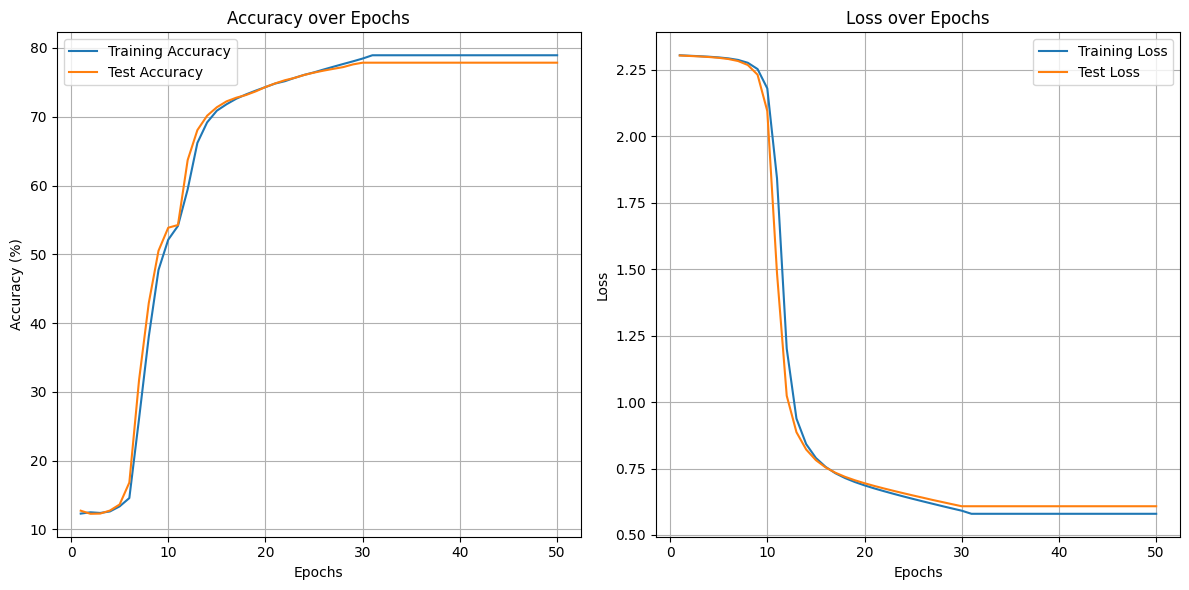

In [64]:
# Define the number of epochs
epochs_range = range(1, len(train_accuracies) + 1)

# Create a figure for the plots
plt.figure(figsize=(12, 6))

# Plot Training and Test Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label="Training Accuracy")
plt.plot(epochs_range, test_accuracies, label="Test Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# Plot Training and Test Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

## 7. Model Saving and Loading

### 7.1. Model Saving

In [65]:
torch.save(model.state_dict(), "model2.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


### 7.2. Model Saving Loading

In [66]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # Convolutional Layer: 1 input channel, 16 output channels, 3x3 kernel
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max Pooling: Downsample spatial dimensions by a factor of 2

            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # Convolutional Layer: 16 input channels, 32 output channels, 3x3 kernel
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max Pooling: Downsample spatial dimensions by a factor of 2

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Convolutional Layer: 32 input channels, 64 output channels, 3x3 kernel
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max Pooling: Downsample spatial dimensions by a factor of 2
        )
        self.flatten = nn.Flatten()  # Flatten the output from convolutional layers for the fully connected layers
        self.fc_stack = nn.Sequential(
            nn.Linear(64 * 3 * 3, 128),  # Fully connected layer: 64*3*3 input features, 128 output features
            nn.ReLU(),  # Activation function
            nn.Linear(128, 10),  # Fully connected layer: 128 input features, 10 output features (number of classes)
        )

    def forward(self, x):
        x = self.conv_relu_stack(x)  # Apply the convolutional and pooling layers
        x = self.flatten(x)          # Flatten the output for the fully connected layers
        x = self.fc_stack(x)         # Apply the fully connected layers
        return x

# Instantiate the model and move it to the specified device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

model.load_state_dict(torch.load("model2.pth", weights_only=True))

<All keys matched successfully>

torch.Size([1, 28, 28])
Predicted: "Ankle boot", Actual: "Ankle boot"


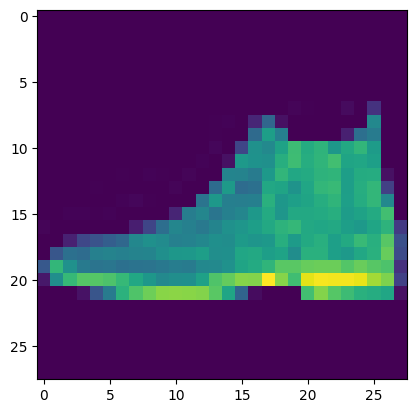

In [67]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    print(x.shape)
    plt.imshow(x.squeeze())
    x = x.to(device)
    x = x.unsqueeze(0)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')